In [ ]:
import cv2
import torch
import numpy as np
from kornia.feature import LoFTR
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

In [ ]:
image1=load_image('1.jpg')
image2=load_image('12.jpg')

In [ ]:
def match_loftr(image1, image2):
    loftr = LoFTR(pretrained='outdoor')
    image1_t = torch.from_numpy(image1 / 255.).float()[None, None]
    image2_t = torch.from_numpy(image2 / 255.).float()[None, None]

    match_dict = loftr({'image0': image1_t, 'image1': image2_t})
    pts0 = match_dict['keypoints0'].cpu().numpy()
    pts1 = match_dict['keypoints1'].cpu().numpy()
    return pts0, pts1

def overlap_region(kp1, kp2):
    min_x1, min_y1 = np.min(kp1, axis=0)
    max_x1, max_y1 = np.max(kp1, axis=0)
    region1 = (min_x1, min_y1, max_x1 - min_x1, max_y1 - min_y1)

    min_x2, min_y2 = np.min(kp2, axis=0)
    max_x2, max_y2 = np.max(kp2, axis=0)
    region2 = (min_x2, min_y2, max_x2 - min_x2, max_y2 - min_y2)

    return region1, region2

def resize(image, region):
    x, y, w, h = region
    x, y, w, h = int(x), int(y), int(w), int(h)
    return cv2.resize(image[y:y+h, x:x+w], (w, h))

Total Process Time: 16.876070737838745 seconds


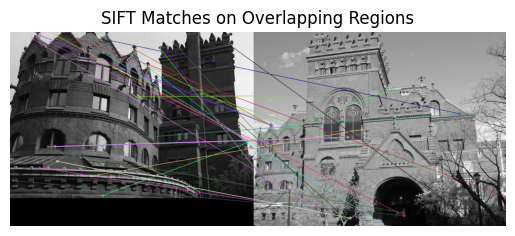

In [ ]:

start = time.time()
kp0_overlap, kp1_overlap = match_loftr(image1, image2)

overlap_region1, overlap_region2 = overlap_region(kp0_overlap, kp1_overlap)

resized_region1 = resize(image1, overlap_region1)
resized_region2 = resize(image2, overlap_region2)

sift_overlap = cv2.SIFT_create()
kp1_sift_overlap, des1_sift_overlap = sift_overlap.detectAndCompute(resized_region1, None)
kp2_sift_overlap, des2_sift_overlap = sift_overlap.detectAndCompute(resized_region2, None)

bf_overlap = cv2.BFMatcher()
matches_sift_overlap = bf_overlap.knnMatch(des1_sift_overlap, des2_sift_overlap, k=2)

end = time.time()
duration = end - start
print(f"Total Process Time: {duration} seconds")


good_matches = []
for m, n in matches_sift_overlap:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw SIFT matches
matched_image = cv2.drawMatches(resized_region1, kp1_sift_overlap, resized_region2, kp2_sift_overlap, good_matches, None, flags=2)

plt.imshow(matched_image)
plt.axis('off')
plt.title("SIFT Matches on Overlapping Regions")
plt.show()

In [ ]:
#Benchmarking analysis
# LoFTR matches
loftr_matches_overlap = len(kp0_overlap)
# SIFT matches
sift_matches_overlap = len([m for m, n in matches_sift_overlap if m.distance < 0.75 * n.distance])
print(f"Number of LoFTR matches on full images: {loftr_matches_overlap}")
print(f"Number of good SIFT matches in resized overlapping regions: {sift_matches_overlap}")

Number of LoFTR matches on full images: 382
Number of good SIFT matches in resized overlapping regions: 32


### Feature matching without overlap detection using SIFT only

SIFT processing time: 0.47107625007629395 seconds


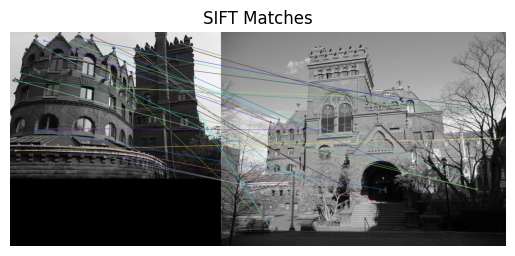

In [ ]:
# Using SIFT for feature extraction
sift = cv2.SIFT_create()
start = time.time()
kp1_sift, des1_sift = sift.detectAndCompute(image1, None)
kp2_sift, des2_sift = sift.detectAndCompute(image2, None)
sift_time = time.time() - start
print(f"SIFT processing time: {sift_time} seconds")

# Using BFMatcher for matching descriptors
bf_sift = cv2.BFMatcher()
matches_sift = bf_sift.knnMatch(des1_sift, des2_sift, k=2)

# Apply ratio test
good_matches = []
for m, n in matches_sift:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw SIFT matches
output_image = cv2.drawMatches(image1, kp1_sift, image2, kp2_sift, good_matches, None, flags=2)

plt.imshow(output_image)
plt.axis('off')
plt.title("SIFT Matches")
plt.show()

In [ ]:
#Benchmarking analysis
# SIFT matches
sift_matches = len([m for m, n in matches_sift if m.distance < 0.75 * n.distance])
print(f"Number of good SIFT matches on full images: {sift_matches}")

Number of good SIFT matches on full images: 34


### Feature matching without overlap detection using LoFTR only

In [ ]:
# Match features with LoFTR
start = time.time()
kp0, kp1 = match_loftr(image1, image2)
loftr_time = time.time() - start
print(f"LoFTR processing time: {loftr_time} seconds")

LoFTR processing time: 16.95064091682434 seconds


In [ ]:
def draw_matches(image1, image2, kp1, kp2):
    h1, w1, h2, w2 = image1.shape[0], image1.shape[1], image2.shape[0], image2.shape[1]
    height = max(h1, h2)
    width = w1 + w2
    output = np.zeros((height, width), dtype=np.uint8)
    output[:h1, :w1] = image1
    output[:h2, w1:w1+w2] = image2

    for p1, p2 in zip(kp1, kp2):
        p1 = (int(p1[0]), int(p1[1]))
        p2 = (int(p2[0] + w1), int(p2[1]))
        cv2.line(output, p1, p2, 255, 1)
    return output

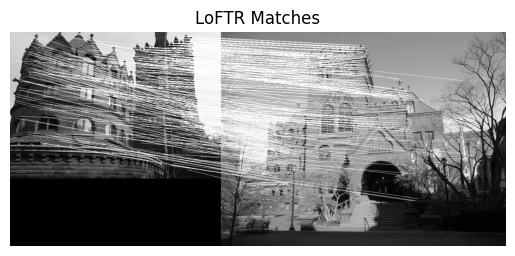

In [ ]:
output_image = draw_matches(image1, image2, kp0, kp1)
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.title("LoFTR Matches")
plt.show()

In [ ]:
#Benchmarking analysis
# LoFTR matches
loftr_matches = len(kp0)
print(f"Number of LoFTR matches on full images: {loftr_matches}")


Number of LoFTR matches on full images: 382


Benchmarking analysis conclusion: Although the number of matches might be lower in the confined overlapping regions, compared with those generated directly on the full images, they could potentially be more relevant to our 3D reconsruction task. This can be verified by the low reprojection error.

### Feature Matching without overlap detection but with a method ensemble of LoFTR and SIFT

Use LoFTR to initially identify broad matches across the images and then apply SIFT for detailed matching within the regions identified by LoFTR.

In [ ]:
def is_near_loftr(sift_kp, loftr_match, threshold=10):
    sift_point = np.array([sift_kp.pt[0], sift_kp.pt[1]])

    for point in loftr_match:
        distance = np.linalg.norm(sift_point - point)
        if distance < threshold:
            return True

    return False

Total Process Time: 30.15300703048706 seconds


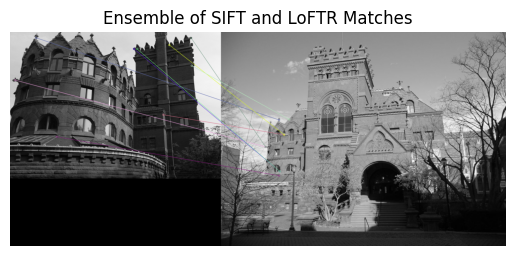

In [ ]:
start = time.time()

kp0_ensemble, kp1_ensemble = match_loftr(image1, image2)

sift_ensemble = cv2.SIFT_create()
kp1_sift_ensemble, des1_sift_ensemble = sift_ensemble.detectAndCompute(image1, None)
kp2_sift_ensemble, des2_sift_ensemble = sift_ensemble.detectAndCompute(image2, None)


filtered_kp1 = [kp for kp in kp1_sift_ensemble if is_near_loftr(kp, kp0_ensemble)]
filtered_kp2 = [kp for kp in kp2_sift_ensemble if is_near_loftr(kp, kp1_ensemble)]

_, filtered_des1 = sift_ensemble.compute(image1, filtered_kp1)
_, filtered_des2 = sift_ensemble.compute(image2, filtered_kp2)


bf_ensemble = cv2.BFMatcher()
matches_sift_ensemble = bf_ensemble.knnMatch(filtered_des1, filtered_des2, k=2)


end = time.time()
duration = end - start
print(f"Total Process Time: {duration} seconds")



good_matches = [m for m, n in matches_sift_ensemble if m.distance < 0.75 * n.distance]

output_image = cv2.drawMatches(image1, filtered_kp1, image2, filtered_kp2, good_matches, None, flags=2)

plt.imshow(output_image)
plt.axis('off')
plt.title("Ensemble of SIFT and LoFTR Matches")
plt.show()


In [ ]:
#benchmarking
matches_ensemble = len(good_matches)
print(f"Number of good matches with ensemble: {matches_ensemble}")

Number of good matches with ensemble: 9


#